# Import required libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets

In [ ]:
customers = pd.read_csv("/content/Customers.csv")
transactions = pd.read_csv("/content/Transactions.csv")


In [ ]:
# Data Preparation
# Aggregate transaction data per customer
customer_transactions = transactions.groupby("CustomerID").agg({
    'TotalValue': 'sum',  # Total spending
    'TransactionID': 'count',  # Number of transactions
    'Quantity': 'sum',  # Total items purchased
}).rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'TransactionCount',
    'Quantity': 'TotalItemsPurchased'
}).reset_index()


In [ ]:
# Merge with customer profiles
customer_data = pd.merge(customers, customer_transactions, on="CustomerID", how="left")


In [ ]:
# Handle missing values (fill NA with 0 for customers without transactions)
customer_data.fillna({
    'TotalSpending': 0,
    'TransactionCount': 0,
    'TotalItemsPurchased': 0
}, inplace=True)

In [ ]:
# Convert categorical columns to numerical values for clustering
customer_data['Region'] = customer_data['Region'].astype('category').cat.codes

# Feature selection for clustering
features = ['Region', 'TotalSpending', 'TransactionCount', 'TotalItemsPurchased']
X = customer_data[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


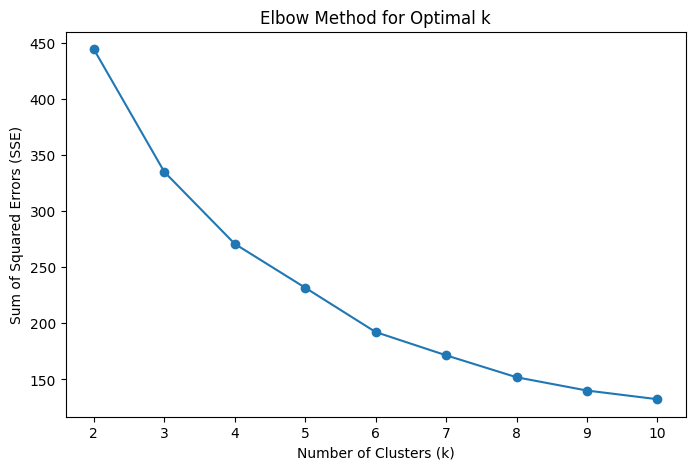

In [ ]:
# Clustering using K-Means
# Determine the optimal number of clusters using the Elbow method
sse = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()

In [ ]:
# Fit KMeans with the chosen number of clusters (e.g., 4 clusters)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_scaled)
customer_data['Cluster'] = kmeans.labels_

# Calculate clustering metrics
db_index = davies_bouldin_score(X_scaled, kmeans.labels_)
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)


Davies-Bouldin Index: 1.0175260538035276
Silhouette Score: 0.2990395655075253


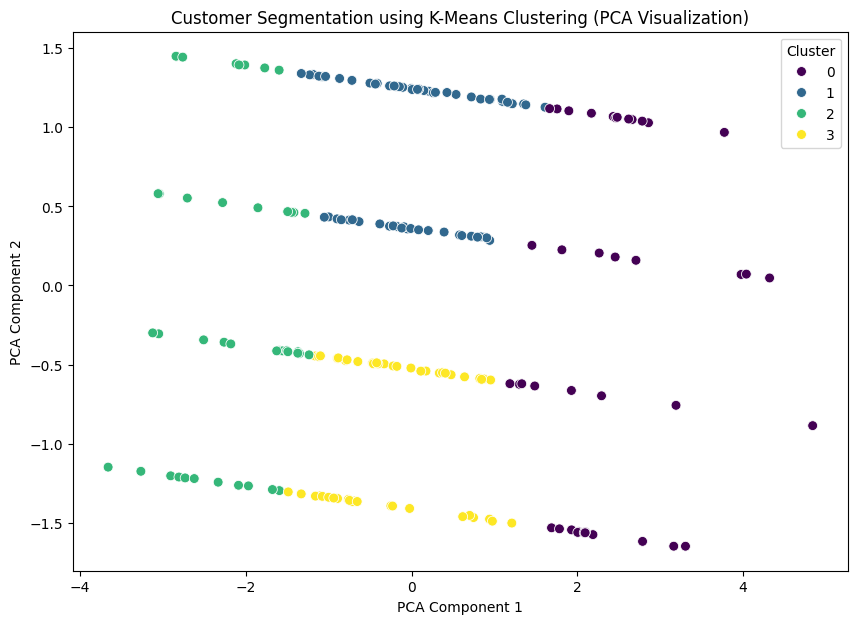

In [ ]:
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")

# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=customer_data['Cluster'], palette='viridis', s=50)
plt.title('Customer Segmentation using K-Means Clustering (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [ ]:

# Save clustering results to a PDF report
from fpdf import FPDF

class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Customer Segmentation Report', 0, 1, 'C')

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(5)

    def chapter_body(self, body):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, body)
        self.ln()

pdf = PDF()
pdf.add_page()
pdf.chapter_title('Clustering Results')
pdf.chapter_body(f'Number of Clusters: {optimal_k}\n\n'
                  f'Davies-Bouldin Index: {db_index}\n'
                  f'Silhouette Score: {silhouette_avg}')
pdf.output("FirstName_LastName_Clustering.pdf")

# Save the clustering code in a notebook
# (Rename file appropriately when saving in Jupyter Notebook)


''

In [ ]:
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=296e12761ebbeb891c6a0ef388b884bff4d0bc8f5664bb0f04457b952fe43293
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf
